# Evaluating Strategy built from Regression Model

In [25]:
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
import warnings
warnings.filterwarnings("ignore")

In [27]:
indicepanel = pd.read_csv('../data/stocks/indices/indicepanel.csv', index_col="Date")
indicepanel.head()

,spy,spy_lag1,sp500,nasdaq,dji,cac40,daxi,aord,hsi,nikkei,Price
Date,,,,,,,,,,,
2008-01-04,-1.529998,-1.570008,-3.540039,-40.879883,2.43945,5.489746,-27.990235,-2.300293,515.349609,-464.320313,143.339996
2008-01-07,0.270004,-1.529998,-29.940064,-56.930176,-245.40918,-111.689941,-102.709961,-27.500000,216.951171,-48.830078,141.809998
2008-01-08,-2.990006,0.270004,1.640015,-7.179931,19.75000,44.509766,33.680176,-33.899902,-354.060547,99.370117,142.080002
2008-01-09,0.589997,-2.990006,-25.459961,-63.119873,-230.69043,-17.109864,-5.270020,-12.900390,768.359375,234.450195,139.089996
2008-01-10,1.100006,0.589997,16.530029,8.270019,142.90039,9.140137,-40.120117,-100.200196,-195.560547,-158.209961,139.679993


In [28]:
trainset = indicepanel.iloc[-2000:-1000, :]
testset = indicepanel.iloc[-1000:, :]

In [29]:
formula = 'spy~spy_lag1+sp500+nasdaq+dji+cac40+aord+daxi+nikkei+hsi'
lm = smf.ols(formula=formula, data=trainset).fit()

In [30]:
trainset['PredictedY'] = lm.predict(trainset)
testset['PredictedY'] = lm.predict(testset)

# Profit of Signal-based strategy

If signal > 0, long; otherwise (i.e. signal < 0), short.

In [31]:
# Train
trainset['Order'] = [1 if sig>0 else -1 for sig in trainset['PredictedY']]
trainset['Profit'] = trainset['spy'] * trainset['Order']

trainset['Wealth'] = trainset['Profit'].cumsum()
print('Total profit made in the Train Set: ', trainset['Profit'].sum())

Total profit made in the Train Set:  214.34009500000042


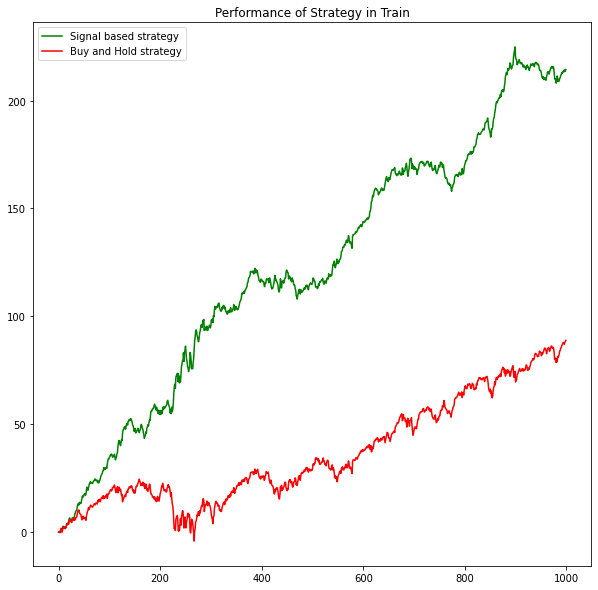

In [32]:
plt.figure(figsize=(10, 10))
plt.title('Performance of Strategy in Train')
plt.plot(trainset['Wealth'].values, color='green', label='Signal based strategy')
plt.plot(trainset['spy'].cumsum().values, color='red', label='Buy and Hold strategy')
plt.legend()
plt.show()

In [33]:
# Test
testset['Order'] = [1 if sig>0 else -1 for sig in testset['PredictedY']]
testset['Profit'] = testset['spy'] * testset['Order']

testset['Wealth'] = testset['Profit'].cumsum()
print('Total profit made in Test: ', testset['Profit'].sum())

Total profit made in Test:  241.0300879999996


# Evaluation of model - Practical Standard

### Method 1: Sharpe Ratio - to measure the excess return (or risk premium) per unit of deviation in an investment asset or a trading strategy, typically referred to as risk

$SR = \frac{Mean of Excess Return}{SD of Excess Return} = \frac{E(R_a - R_b)}{sqrt(Var(R_a - R_b))}$

$SR_{year} = \sqrt{252 SR_{day}}$

Note: There are 252 trading days a year.

In [34]:
trainset['Wealth'] = trainset['Wealth'] + trainset.loc[trainset.index[0], 'Price']
testset['Wealth'] = testset['Wealth'] + testset.loc[testset.index[0], 'Price']

In [35]:
# Sharpe Ratio on Train data
trainset['Return'] = np.log(trainset['Wealth']) - np.log(trainset['Wealth'].shift(1))
dailyr = trainset['Return'].dropna()
train_dailysr = dailyr.mean()/dailyr.std(ddof=1)
train_yearlysr = (252**0.5)*dailyr.mean()/dailyr.std(ddof=1)

print('[Train Set] Daily Sharpe Ratio is ', train_dailysr)
print('[Train Set] Yearly Sharpe Ratio is ', train_yearlysr)

[Train Set] Daily Sharpe Ratio is  0.17965076303258012
[Train Set] Yearly Sharpe Ratio is  2.851867450963218


In [36]:
# Sharpe Ratio in Test data
testset['Return'] = np.log(testset['Wealth']) - np.log(testset['Wealth'].shift(1))
dailyr = testset['Return'].dropna()
test_dailysr = dailyr.mean()/dailyr.std(ddof=1)
test_yearlysr = (252**0.5)*dailyr.mean()/dailyr.std(ddof=1)

print('[Test Set] Daily Sharpe Ratio is ', test_dailysr)
print('[Test Set] Yearly Sharpe Ratio is ', test_yearlysr)

[Test Set] Daily Sharpe Ratio is  0.13035126208575046
[Test Set] Yearly Sharpe Ratio is  2.06926213537379


### Method 2: Maximum Drawdown - the maximum percentage decline in the strategy from the historical peak profit at each point in time

$drawdown = \frac{maximum - wealth}{maximum}$

In [37]:
# Maximum Drawdown in Train data
# compute the peak of the wealth process
trainset['Peak'] = trainset['Wealth'].cummax()
trainset['Drawdown'] = (trainset['Peak'] - trainset['Wealth'])/trainset['Peak']
print('[Train Set] Maximum Drawdown in Train is ', trainset['Drawdown'].max())

[Train Set] Maximum Drawdown in Train is  0.06069016443644383


In [38]:
# Maximum Drawdown in Test data
# compute the peak of the wealth process
testset['Peak'] = testset['Wealth'].cummax()
testset['Drawdown'] = (testset['Peak'] - testset['Wealth'])/testset['Peak']
print('[Test Set] Maximum Drawdown in Test is ', testset['Drawdown'].max())

[Test Set] Maximum Drawdown in Test is  0.11719899524631659


In [40]:
evaluation = pd.DataFrame(index=['Sharpe Ratio', 'Maximum Drawdown'], columns=['TrainSet', 'TestSet'])
evaluation['TrainSet'] = ['%2.2f%%' % train_yearlysr, '%2.2f%%' % (trainset['Drawdown'].max()*100)]
evaluation['TestSet'] = ['%2.2f%%' % test_yearlysr, '%2.2f%%' % (testset['Drawdown'].max()*100)]
evaluation


,TrainSet,TestSet
Sharpe Ratio,2.85%,2.07%
Maximum Drawdown,6.07%,11.72%
